# Deep learning With image

- *Aims:*


## Loading and visualizing the data

We will consider the MNIST database which contains 60,000 28x28 grayscale images of the 10 digits, along with a test set of 10,000 images. In a first time, we load the data.

In [1]:
from tensorflow.keras.datasets import mnist,fashion_mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation,Flatten,BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPooling2D, InputLayer,ReLU
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.utils import to_categorical, plot_model
import matplotlib
import matplotlib.pyplot as plt
import scipy
import scipy.ndimage
import numpy as np
from tensorflow.keras import backend as K

In [2]:
def loadMNISTAsVector(subset=10000) :
    nb_classes=10
    (X_train_img, y_train_real), (X_test_img, y_test_real) = fashion_mnist.load_data()
    X_train_vect = X_train_img[:subset].reshape(subset, 784)
    X_test_vect = X_test_img.reshape(10000, 784)
    X_train_vect = X_train_vect.astype("float32")
    X_test_vect = X_test_vect.astype("float32")
    X_train_vect /= 255
    X_test_vect /= 255
    y_train_cat = to_categorical(y_train_real[:subset], nb_classes)
    y_test_cat = to_categorical(y_test_real, nb_classes)
    return (X_train_vect, y_train_cat), (X_test_vect, y_test_cat)



(X_train_vect, y_train_cat), (X_test_vect, y_test_cat) =loadMNISTAsVector(subset=50000) #to limit the wating time, as first step we can just load 10000 samples


4422102/4422102 [==============================] - 1s 0us/step


Ploting the data
   

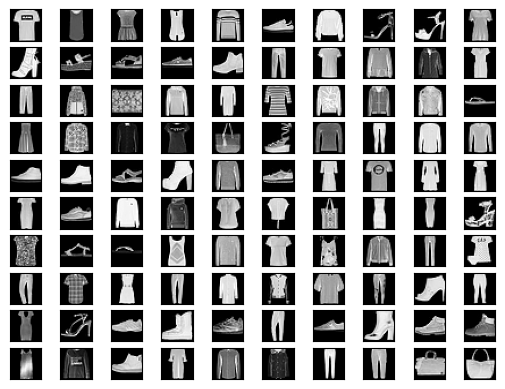

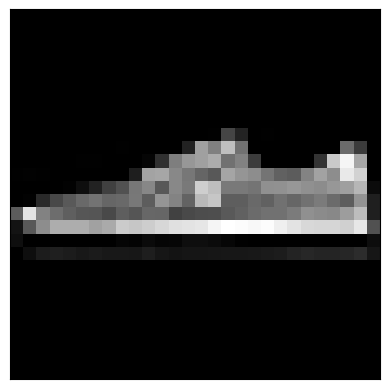

In [3]:
def plot_10_by_10_images(images):
    """ Plot 100 MNIST images in a 10 by 10 table. Note that we crop
    the images so that they appear reasonably close together.  The
    image is post-processed to give the appearance of being continued."""
    fig = plt.figure()
    #image = np.concatenate(images, axis=1)
    for x in range(10):
        for y in range(10):
            ax = fig.add_subplot(10, 10, 10*y+x+1)
            plt.imshow(images[10*y+x+1].reshape(28, 28))
            plt.gray()
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)
    plt.show()

def plot_mnist_digit(image):
    """ Plot a single MNIST image."""
    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1)
    plt.imshow(image.reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    plt.show()



plot_10_by_10_images(X_train_vect)

plot_mnist_digit(X_train_vect[14])

Print the shape of the data, the miminum, the maximum and comment them.

In [4]:
X_train_vect.shape, X_test_vect.shape

((50000, 784), (10000, 784))

In [5]:
y_train_cat.shape, y_train_cat.shape #10 classes

((50000, 10), (50000, 10))

In [6]:
print(X_train_vect.min(), X_train_vect.max())  #values comprised between 0 and 1

0.0 1.0


## Learning the network

The next task is to build the network.

In the learn model function, the neural networks shape is obtained by using the keras functions :
* __model.add(InputLayer(shape=(nbinput,)))__ : which adds an yhe imput layer to the network. [input_shape=(nbinput,)] corresponds to the shape of the input data
* __model.add(Dense(nbhiden, [activation='activationfunction']))__ : which adds an hidden layer to the network. nbhidden is the number of hidden nodes.  [activation='activationfunction'] is the activation function of the layer
* __model.add(Dropout(value))__ : apply dropout to the layer (to avoid overfitting)
* __model.add(BatchNormalization())__: apply batch normalization to the layer (to avoid overfitting)

The possible activation fonctions are :
* Relu
* Sigmoid
* softmax (for the slast layer of a multiclass classifier)

The possible loss functions are
* binary_crossentropy (for binary classification)
* categorical_cross_entropy (for multi class classification)
* mean_squared_error (for regression)


Here is the simplest network you can build :

In [35]:
def getSimplePerceptron(nb_classes=10):
    model = Sequential()
    model.add(InputLayer(input_shape=(784)))

    layers = [2048, 2048]
    for l in layers:
      model.add(Dense(l,activation="linear"))
      model.add(BatchNormalization())
      model.add(ReLU())
      model.add(Dropout(0.75))

    model.add(Dense(nb_classes, activation='softmax'))

    opt = Adam(lr= 0.0001)
    model.compile(loss='categorical_crossentropy',metrics=['accuracy'],  optimizer=opt)
    return model

model_simple=getSimplePerceptron()
model_simple.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 module_wrapper (ModuleWrap  (None, 1024)              803840    
 per)                                                            
                                                                 
 batch_normalization_10 (Ba  (None, 1024)              4096      
 tchNormalization)                                               
                                                                 
 re_lu_10 (ReLU)             (None, 1024)              0         
                                                                 
 module_wrapper_1 (ModuleWr  (None, 1024)              0         
 apper)                                                          
                                                                 
 module_wrapper_2 (ModuleWr  (None, 1024)              1049600   
 apper)                                               

\__Question__: Describe the neural networks and exaplain the computation of the number of parameters of your network

The Neural Network above is composed of three types of layers;
- first layer represent the input layer which takes the input features (784).
- second we have 2 hidden layers of 2048 units.
- third we have the output layer (Dense) with 10 units (10 classes).

The number of parameters is computed by the total number of weights + the total number of biases. The total number of weights equals the sum of the products of each pair of adjacent layers. The total number of biases is equal to the number of hidden neurons + the number of output neurons.

* total_weights = (784 * 2048)+ (2048 *2048)+ (2048 * 10)
* total_biases = 2048 + 2048 + 10
* total_parameters = 5832714

Then, we learn the parameters of the network

In [8]:
(X_train_vect, y_train_cat), (X_test_vect, y_test_cat) =loadMNISTAsVector()
model=getSimplePerceptron()
batch_size = 64
epochs=25
res = model_simple.fit(X_train_vect, y_train_cat, batch_size=batch_size, epochs=epochs,  verbose=1, validation_data=(X_test_vect, y_test_cat))

Epoch 1/25
157/157 [==============================] - 9s 11ms/step - loss: 1.1276 - accuracy: 0.6723 - val_loss: 0.7797 - val_accuracy: 0.7478
Epoch 2/25
157/157 [==============================] - 1s 9ms/step - loss: 0.8098 - accuracy: 0.7466 - val_loss: 0.7380 - val_accuracy: 0.7808
Epoch 3/25
157/157 [==============================] - 1s 9ms/step - loss: 0.7077 - accuracy: 0.7654 - val_loss: 0.5479 - val_accuracy: 0.8143
Epoch 4/25
157/157 [==============================] - 1s 9ms/step - loss: 0.6214 - accuracy: 0.7890 - val_loss: 0.5233 - val_accuracy: 0.8245
Epoch 5/25
157/157 [==============================] - 1s 9ms/step - loss: 0.5886 - accuracy: 0.7985 - val_loss: 0.5446 - val_accuracy: 0.8208
Epoch 6/25
157/157 [==============================] - 1s 9ms/step - loss: 0.5751 - accuracy: 0.7991 - val_loss: 0.5538 - val_accuracy: 0.8245
Epoch 7/25
157/157 [==============================] - 1s 9ms/step - loss: 0.5330 - accuracy: 0.8135 - val_loss: 0.4783 - val_accuracy: 0.8309
Epoch

## Evaluate The Performances

Plot the train/test curve of the loss and accuracy

Best test accuracy was 0.854000 at epoch 19


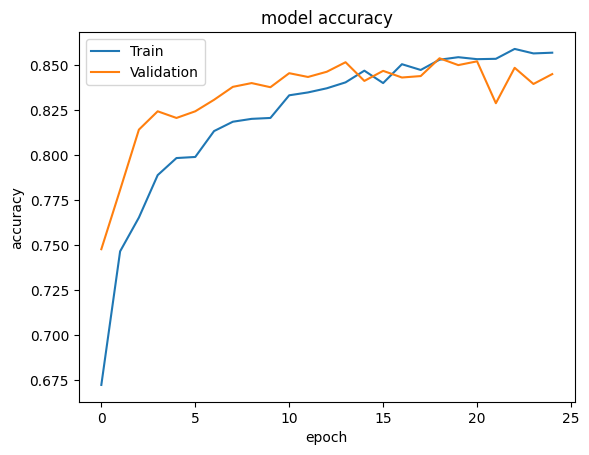

In [9]:
import matplotlib.pyplot as plt
# summarize history for accuracy
plt.plot(res.history['accuracy'])
plt.plot(res.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper left')



best_score = max(res.history['val_accuracy'])
best_epoch = np.array(res.history['val_accuracy']).argmax()+1
print('Best test accuracy was %f at epoch %i' % (best_score, best_epoch))



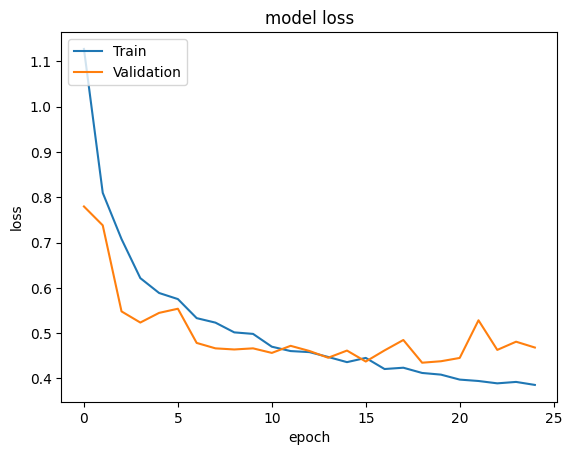

In [10]:
# summarize history for loss
plt.plot(res.history['loss'])
plt.plot(res.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

Last, we analyse the results :

In [11]:
loss_simple,acc_simple = model_simple.evaluate(X_test_vect, y_test_cat,  verbose=0)
index=800
print('The accuracy on the test set is ',(acc_simple*100),'%')

The accuracy on the test set is  84.52000021934509 %


Predict the probabilty distribution on the classes for one image with the function predict and find the most probable class

In [12]:
np.where(y_test_cat[0] == 1)[0][0]  #let's check if the model find the class of the first item

9

In [13]:
y_pred = model_simple.predict(X_test_vect)
y_pred[0]

313/313 [==============================] - 1s 3ms/step


array([1.3778752e-07, 7.2515505e-08, 6.3630085e-07, 1.2032338e-06,
       2.8280417e-07, 8.9217432e-02, 1.1198357e-06, 3.0915456e-02,
       1.4733199e-05, 8.7984902e-01], dtype=float32)

In [14]:
np.where(y_pred[0]==y_pred[0].max())[0][0]  #find the index of the max value (most probable class)
# the model predict correctely the class for the first item

9

## CNN

We will now consider a new kind of network that consider image directly. We load the data as matrix instead of vectors

In [15]:
def loadMNISTAsMaxtrix(subset=10000) :
    nb_classes=10
    img_rows, img_cols = 28, 28
    (X_train_img, y_train_real), (X_test_img, y_test_real) = fashion_mnist.load_data()
    X_train_mat = X_train_img[:subset].reshape(X_train_img[:subset].shape[0], img_rows, img_cols, 1)
    X_test_mat = X_test_img.reshape(X_test_img.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)
    X_train_mat = X_train_mat.astype('float32')
    X_test_mat = X_test_mat.astype('float32')
    X_train_mat /= 255
    X_test_mat /= 255
    y_train_cat = to_categorical(y_train_real[:subset], nb_classes)
    y_test_cat = to_categorical(y_test_real, nb_classes)
    return (X_train_mat, y_train_cat), (X_test_mat, y_test_cat)


In [16]:
(X_train_mat, y_train_cat), (X_test_mat, y_test_cat) =loadMNISTAsMaxtrix(subset=50000)

Compare the shape of the data with the previous approach:

> The main difference between these two approaches is that in the first, data are loaded as 2D vectors, whereas in the second, data are loaded as matrices.



In [17]:
X_train_vect[50]

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.00392157, 0.        ,
       0.        , 0.03529412, 0.02352941, 0.        , 0.        ,
       0.        , 0.09411765, 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.2627451 , 0.81960785, 0.90588236,
       0.972549  , 0.9882353 , 0.98039216, 0.99215686, 0.9647059 ,
       0.80784315, 0.5176471 , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.00392157,
       0.8901961 , 0.9529412 , 0.91764706, 0.91764706, 0.972549  ,
       0.9647059 , 0.93333334, 0.9019608 , 0.91764706, 0.98039

Print the shape of the data and comment it.

In [18]:
X_train_mat.shape

(50000, 28, 28, 1)

The shape is represented in 4D, where the first element represent the number of samples, and 28x28 represent the dimenssion of the images, and 1 represent the color, here form gray to white.

The next task is to build the convolutional neural network (CNN).
In the learn model function, the CNN shape is obtained by using these additional keras functions :
* __model.add(InputLayer(shape=(nbinput,)))__ : which adds an yhe imput layer to the network. [input_shape=(nbinput,)] corresponds to the shape of the input data
* __model.add(Conv2D(nbhiden, [kernel_size=(3, 3)], [padding='same'], [activation='activationfunction']))__ : which adds an convolution hidden layer to the network. nbhidden is the number of hidden nodes.  [kernel_size=(3, 3)] the size of the convolutional kernel and [padding='same'] the way the border of the images are handled
* __model.add(MaxPooling2D(pool_size=(2, 2))__ : pooling operation

Here is one the simplest CNN you can build :

In [19]:
def getCNN(nb_classes=10):
    model = Sequential()
    model.add(InputLayer(input_shape=(28,28,1)))

    #matrix 28x28

    for l in [64, 128]:
      for m in range(3):
        model.add(Conv2D(l, kernel_size=(3, 3), padding='same', activation= 'linear'))     #add convolution layer
        model.add(BatchNormalization()) #add a BatchNormalization
        model.add(ReLU()) #add a relu function
      model.add(MaxPooling2D(pool_size=(2, 2)))  ##pooling


    #transform image to vectors of neurons
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dense(128, activation='relu'))
    model.add(Dense(nb_classes, activation='softmax'))

    opt = Adam(0.0001)
    model.compile(loss='categorical_crossentropy',metrics=['accuracy'],  optimizer=opt)
    return model


model_cnn=getCNN(nb_classes=10)
model_cnn.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 64)        640       
                                                                 
 batch_normalization_4 (Bat  (None, 28, 28, 64)        256       
 chNormalization)                                                
                                                                 
 re_lu_4 (ReLU)              (None, 28, 28, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 64)        36928     
                                                                 
 batch_normalization_5 (Bat  (None, 28, 28, 64)        256       
 chNormalization)                                                
                                                                 
 re_lu_5 (ReLU)              (None, 28, 28, 64)       

In [20]:
batch_size = 256
epochs=20
cnn = model_cnn.fit(X_train_mat, y_train_cat, batch_size=batch_size, epochs=epochs,  verbose=1, validation_data=(X_test_mat, y_test_cat))

Epoch 1/20
196/196 [==============================] - 24s 67ms/step - loss: 0.4955 - accuracy: 0.8249 - val_loss: 2.6242 - val_accuracy: 0.1672
Epoch 2/20
196/196 [==============================] - 13s 67ms/step - loss: 0.2639 - accuracy: 0.9047 - val_loss: 2.2515 - val_accuracy: 0.3316
Epoch 3/20
196/196 [==============================] - 13s 67ms/step - loss: 0.2012 - accuracy: 0.9285 - val_loss: 0.4146 - val_accuracy: 0.8622
Epoch 4/20
196/196 [==============================] - 13s 68ms/step - loss: 0.1586 - accuracy: 0.9444 - val_loss: 0.2682 - val_accuracy: 0.9055
Epoch 5/20
196/196 [==============================] - 13s 68ms/step - loss: 0.1300 - accuracy: 0.9561 - val_loss: 0.2643 - val_accuracy: 0.9037
Epoch 6/20
196/196 [==============================] - 13s 68ms/step - loss: 0.1006 - accuracy: 0.9673 - val_loss: 0.2870 - val_accuracy: 0.9033
Epoch 7/20
196/196 [==============================] - 13s 67ms/step - loss: 0.0783 - accuracy: 0.9756 - val_loss: 0.2572 - val_accuracy:

__Questions__ : As for the dense networks, do the following analysis :
* Plot the train/test curve of the loss and accuracy
* Compute the final accuracy on the test set
* Predict the probabilty distribution on the classes for one image with the function predict and find the most probable class


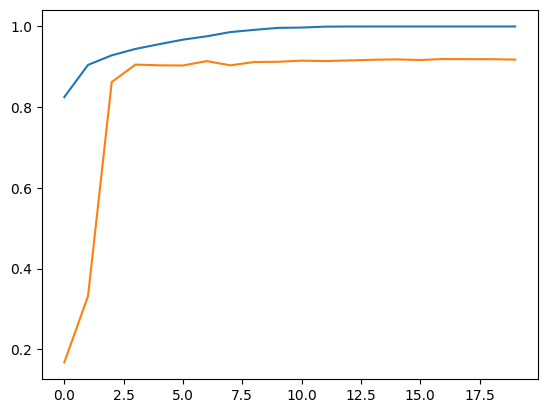

In [21]:
plt.plot(cnn.history['accuracy'])
plt.plot(cnn.history['val_accuracy'])

In [22]:
loss_cnn,acc_cnn = model_cnn.evaluate(X_test_mat, y_test_cat,  verbose=0)
index=800
print('The accuracy on the test set is ',(acc_cnn*100),'%')

The accuracy on the test set is  91.7900025844574 %


As we can see with the CNN we get a best accuracy on the test set than the simple model

In [23]:
model_cnn.predict(X_test_mat)

313/313 [==============================] - 1s 4ms/step


array([[3.5917563e-10, 7.3376150e-10, 2.7253050e-08, ..., 5.5588083e-07,
        5.1389662e-08, 9.9999607e-01],
       [1.3888964e-09, 2.0604814e-13, 1.0000000e+00, ..., 1.4095538e-15,
        4.0238727e-14, 1.0619636e-15],
       [5.6914757e-08, 1.0000000e+00, 1.8548012e-10, ..., 1.1973545e-08,
        5.0331890e-09, 2.9018853e-12],
       ...,
       [5.0932005e-07, 4.0483931e-12, 6.0957067e-10, ..., 1.8274726e-10,
        9.9999940e-01, 1.5156609e-10],
       [1.5082772e-07, 9.9999988e-01, 2.3476820e-10, ..., 1.3093520e-09,
        3.6207533e-11, 2.5481926e-12],
       [7.5508649e-07, 1.9842466e-05, 2.4068142e-05, ..., 2.0643845e-01,
        1.1914162e-05, 3.2477676e-06]], dtype=float32)

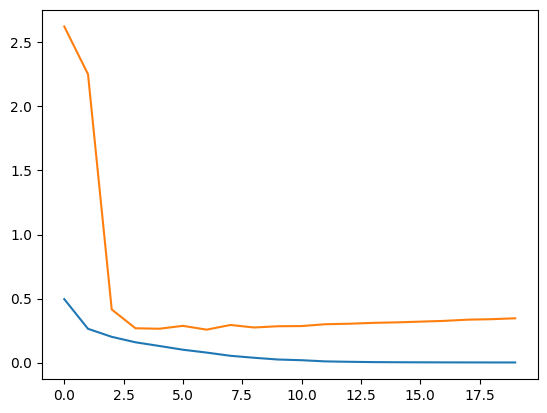

In [24]:
plt.plot(cnn.history['loss'])
plt.plot(cnn.history['val_loss'])

In [26]:
y_predictions = model_cnn.predict(X_test_mat)

313/313 [==============================] - 2s 5ms/step


In [27]:
y_predictions[0]

array([3.5917563e-10, 7.3376150e-10, 2.7253050e-08, 6.9007466e-10,
       8.8541503e-09, 3.3504789e-06, 4.9785221e-11, 5.5588083e-07,
       5.1389662e-08, 9.9999607e-01], dtype=float32)

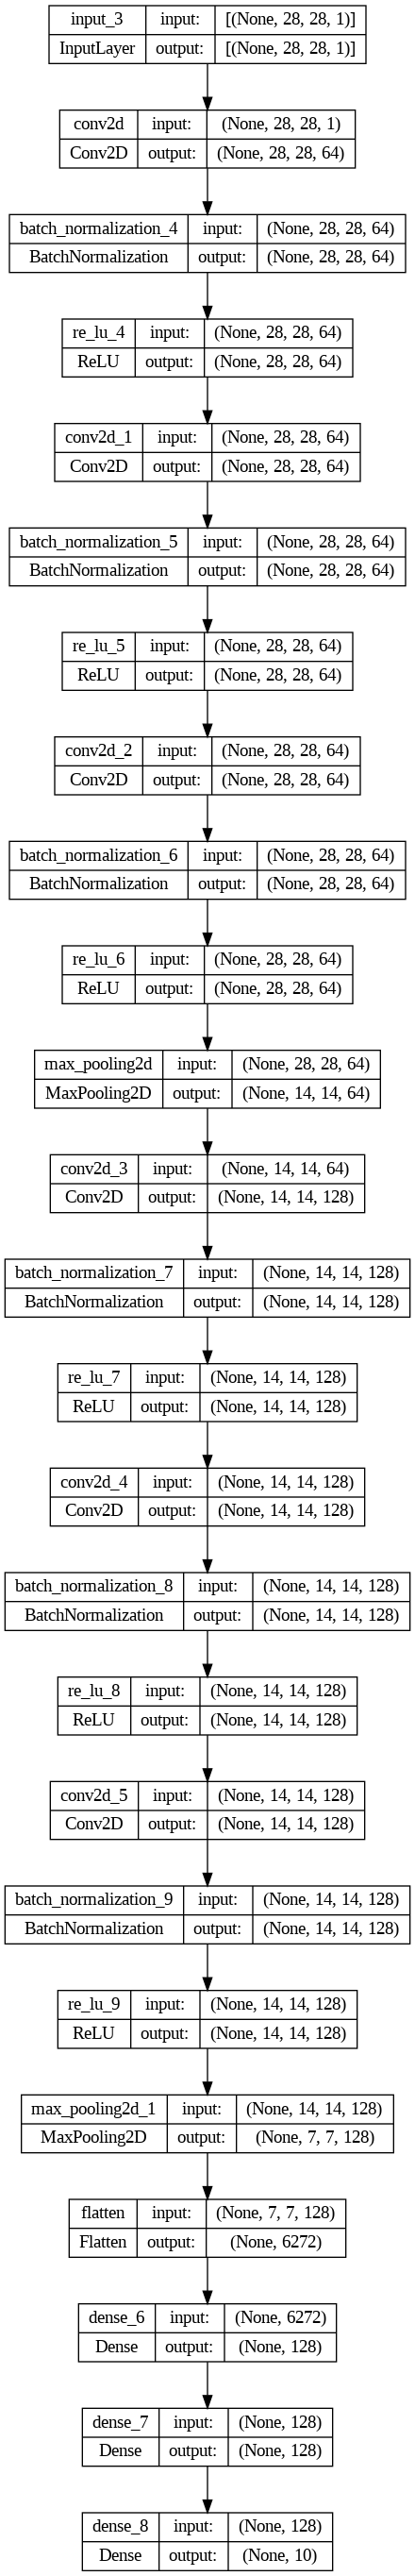

In [28]:
plot_model(model_cnn, show_shapes=True, show_layer_names=True)

In [29]:
!pip install visualkeras

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 993.0/993.0 kB 16.5 MB/s eta 0:00:00


In [30]:
from tensorflow.python.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D, ZeroPadding2D
from collections import defaultdict

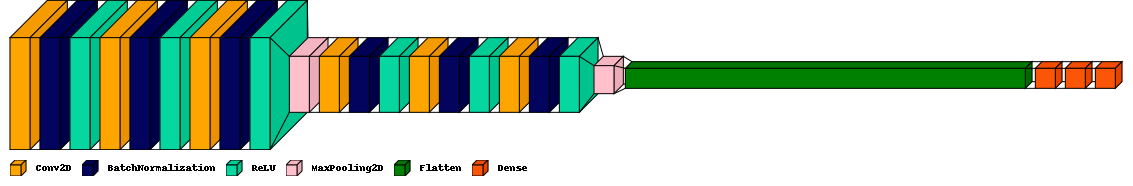

In [31]:

import visualkeras
from tensorflow.keras import layers
from collections import defaultdict
color_map = defaultdict(dict)
color_map[layers.Conv2D]['fill'] = 'orange'
color_map[layers.MaxPooling2D]['fill'] = 'pink'
color_map[layers.BatchNormalization]['fill'] = '#03045e'
color_map[layers.Dense]['fill'] = '#fb5607'
color_map[layers.Flatten]['fill'] = 'green'
visualkeras.layered_view(model_cnn, legend=True,color_map=color_map)



__Questions__ : Compare the results of the two types of networks with respect to their performances and their number of parameters. Use bar plot to compare the different models you applied

Text(0.5, 1.0, 'Accuracy Comparison: CNN vs. Simple Network')

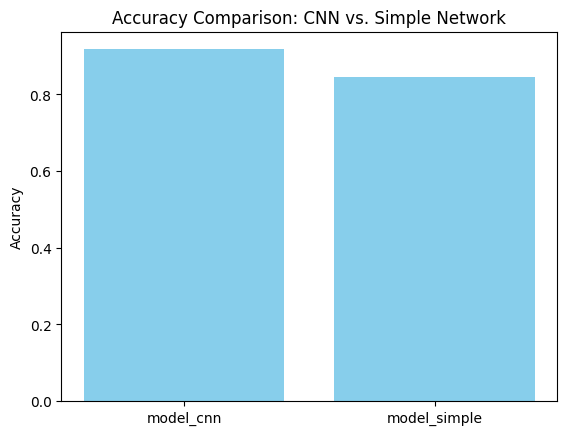

In [33]:
plt.bar(['model_cnn', 'model_simple'], [acc_cnn, acc_simple], color='skyblue')
plt.ylabel('Accuracy')
plt.title('Accuracy Comparison: CNN vs. Simple Network')

Text(0.5, 1.0, 'Loss Comparison: CNN vs. Simple Network')

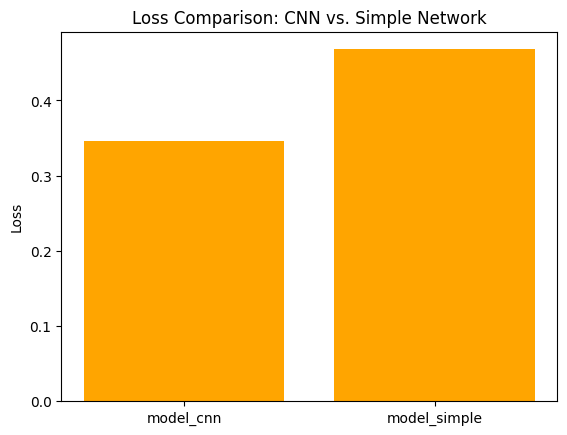

In [34]:
plt.bar(['model_cnn', 'model_simple'], [loss_cnn, loss_simple], color='orange')
plt.ylabel('Loss')
plt.title('Loss Comparison: CNN vs. Simple Network')

## Class Attribution map methods

__Questions__ : use the Xplique package to visualize the most important pixel for a decision :
* Install the package : pip install xplique
* Make a saliency map explainer of the model
* compute the explanation of the 5 five example of the test set and plot them with plot_attributions
* test with other attribution methods

You can find example here :
* the [github page of Xplique](https://github.com/deel-ai/xplique)
* Attribution method [tutorial](https://colab.research.google.com/drive/1XproaVxXjO9nrBSyyy7BuKJ1vy21iHs2)

In [36]:
!pip install xplique

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 149.1/149.1 kB 3.9 MB/s eta 0:00:00


In [37]:
import xplique
from xplique.plots import plot_attributions

In [38]:
y_test_cat[:5]

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0.]], dtype=float32)

Method: Saliency


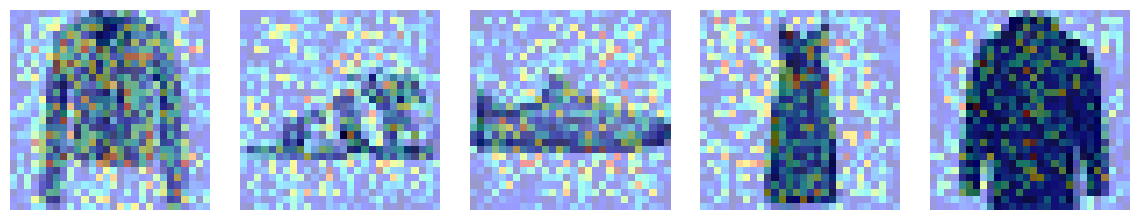



Method: GradientInput


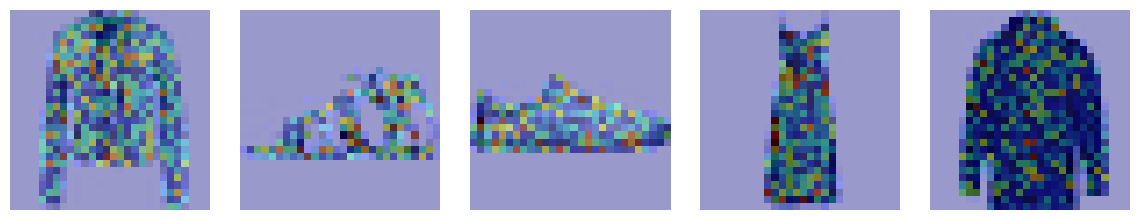

Method: GuidedBackprop


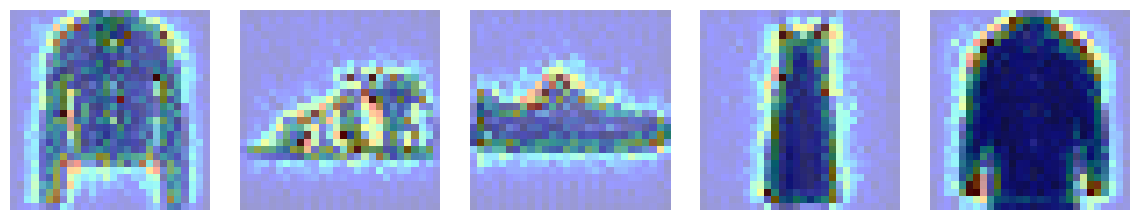



Method: GradCAM


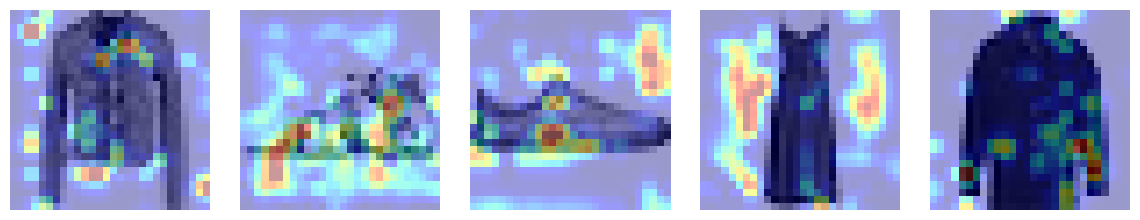

In [47]:
from xplique.attributions import Saliency, GradientInput, GuidedBackprop, GradCAM
import tensorflow.keras.applications as app

X = X_test_mat[10:15]
Y = y_test_cat[10:15]

explainers = [
             Saliency(model_cnn),
             GradientInput(model_cnn),
             GuidedBackprop(model_cnn),
             GradCAM(model_cnn)
             ]

for explainer in explainers:

  explanations = explainer(X, Y)

  print(f"Method: {explainer.__class__.__name__}")
  plot_attributions(explanations, X, img_size=2., cmap='jet', alpha=0.4,
                    cols=len(X), absolute_value=True, clip_percentile=0.5)
  plt.show()
  print("\n")